Source of inspiration for this model: https://www.kaggle.com/code/imsparsh/gtzan-genre-classification-deep-learning-val-92-4/notebook

In [56]:
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import matplotlib as plt
import librosa
import os
import subprocess
import csv
from sklearn import metrics, model_selection, preprocessing

Define paths for this model

In [57]:
absolute_path = "f:\\AI Projects\\Music Classification"
relative_path = "Data\\GTZAN\\genres"
full_path = os.path.join(absolute_path, relative_path)
print(full_path)

f:\AI Projects\Music Classification\Data\GTZAN\genres


List all music genres contained in this dataset

In [58]:
generes_list = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

In [59]:
len(generes_list)

10

Read in the metadata

In [60]:
GTZAN_path = os.path.join(absolute_path,"Data\\GTZAN\genres")
file_path = os.path.join(GTZAN_path,"metadata.csv")
metadata = pd.read_csv(file_path)
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav-0,4.535147,0.340607,0.122398,1773.076114,1955.868447,3688.494873,0.086391,123.046875,-120.494301,...,9.283965,-5.682326,6.937242,-8.601155,-2.293055,-3.826715,1.019838,-2.412001,2.953042,blues
1,blues.00000.wav-1,4.535147,0.339364,0.127939,1803.120119,2080.744242,3999.078369,0.074787,123.046875,-129.895981,...,9.417705,-4.340737,7.461563,-2.396798,5.010379,-2.351950,0.144454,-3.089383,1.655918,blues
2,blues.00000.wav-2,4.535147,0.353243,0.133503,1696.046590,2005.172557,3666.302490,0.071120,123.046875,-112.161453,...,12.625378,-5.172403,7.630077,-9.772185,-0.666326,-2.126123,1.459213,-3.145484,2.411724,blues
3,blues.00000.wav-3,4.535147,0.363599,0.136399,1838.935722,2056.596597,4000.726318,0.083897,129.199219,-104.236809,...,10.776512,-3.352736,5.841449,-6.146827,1.855989,-1.923221,-0.356437,-3.449448,2.081537,blues
4,blues.00000.wav-4,4.535147,0.371211,0.128614,1860.273385,2067.494800,4014.349365,0.084191,123.046875,-107.887718,...,11.879320,-7.173142,6.693336,-5.317769,5.295383,-2.547254,0.429121,-2.686537,1.922374,blues


Use all 100 samples for training data

Hand picked songs for test data
E.g Livin on a prayer
Don't stop believin
Master of puppets
Smells like teens spirit
As it was
All too well
Beethoven symphony 9


In [61]:
print(list(metadata.columns[metadata.isnull().any()]))

[]


No NA or null values in the metadata

Add labels to each file 

In [62]:
label_index = dict()
index_label = dict()

for i, x in enumerate(metadata.label.unique()):
    label_index[x] = i
    index_label[i] = x

metadata.label = [label_index[l] for l in metadata.label]
metadata.head()

,filename,length,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav-0,4.535147,0.340607,0.122398,1773.076114,1955.868447,3688.494873,0.086391,123.046875,-120.494301,...,9.283965,-5.682326,6.937242,-8.601155,-2.293055,-3.826715,1.019838,-2.412001,2.953042,0
1,blues.00000.wav-1,4.535147,0.339364,0.127939,1803.120119,2080.744242,3999.078369,0.074787,123.046875,-129.895981,...,9.417705,-4.340737,7.461563,-2.396798,5.010379,-2.351950,0.144454,-3.089383,1.655918,0
2,blues.00000.wav-2,4.535147,0.353243,0.133503,1696.046590,2005.172557,3666.302490,0.071120,123.046875,-112.161453,...,12.625378,-5.172403,7.630077,-9.772185,-0.666326,-2.126123,1.459213,-3.145484,2.411724,0
3,blues.00000.wav-3,4.535147,0.363599,0.136399,1838.935722,2056.596597,4000.726318,0.083897,129.199219,-104.236809,...,10.776512,-3.352736,5.841449,-6.146827,1.855989,-1.923221,-0.356437,-3.449448,2.081537,0
4,blues.00000.wav-4,4.535147,0.371211,0.128614,1860.273385,2067.494800,4014.349365,0.084191,123.046875,-107.887718,...,11.879320,-7.173142,6.693336,-5.317769,5.295383,-2.547254,0.429121,-2.686537,1.922374,0


Shuffle the dataset

In [63]:
seed = 12
np.random.seed(seed)
df_shuffle = metadata.sample(frac=1, random_state=seed).reset_index(drop=True)
df_shuffle.drop(['filename','length'],axis=1,inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

In [64]:
X_train, df_test_valid_X, y_train, df_test_valid_y = model_selection.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)

X_dev, X_test, y_dev, y_test = model_selection.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

Scale the features

In [65]:
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [66]:
dropout_rate = 0.3

model = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(dropout_rate),
    k.layers.Dense(10, activation='softmax'),
])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              28672     
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)              

In [103]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [104]:
epoch = 500
batch_size = 128

history = model.fit(X_train,y_train,validation_data=(X_dev,y_dev),epochs=epoch,batch_size=batch_size)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.2232 - accuracy: 0.9924 - val_loss: 5.6228 - val_accuracy: 0.9040
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9921 - val_loss: 5.1159 - val_accuracy: 0.8973
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.1292 - accuracy: 0.9910 - val_loss: 4.9069 - val_accuracy: 0.8948
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.2338 - accuracy: 0.9890 - val_loss: 4.2399 - val_accuracy: 0.8923
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9905 - val_loss: 4.4424 - val_accuracy: 0.8981
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.9912 - val_loss: 4.1733 - val_accuracy: 0.8998
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0944 - accuracy: 0.9912 - val_loss: 4.4944 - val_accuracy: 0.8998
Epoch 8/500


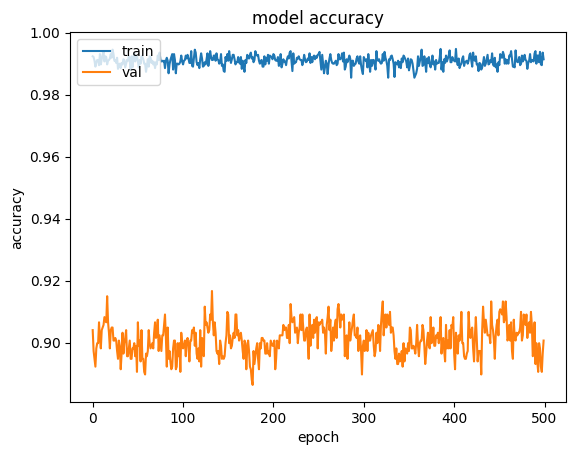

In [105]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

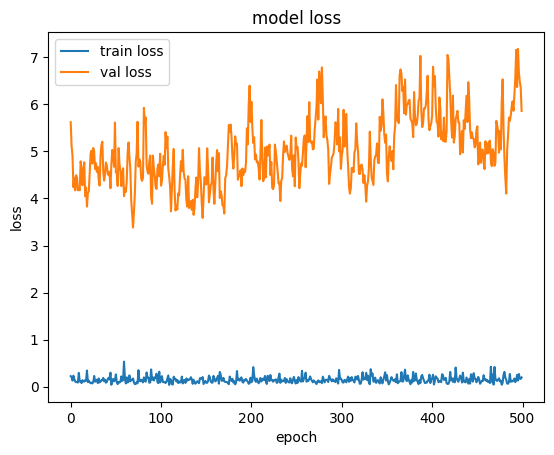

In [106]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss','val loss'], loc='upper left')
plt.show()

In [107]:
loss, accuracy = model.evaluate(X_test,y_test,batch_size=batch_size)

print(f"Loss: {round(loss,4)}")
print(f"Accuracy: {round(accuracy * 100,2)}%")

5/5 [==============================] - 0s 3ms/step - loss: 10.8939 - accuracy: 0.8840
Loss: 10.8939
Accuracy: 88.4%


Evaluation accuracy currently sitting somewhere between **85%** to **90%**

## Testing the model with my own samples (not part of the GTZAN dataset)

In [108]:
own_genre_list = ["classical"]#,"metal","rock"]
own_path = os.path.join(absolute_path,"Data\\Own_data")

def generate_test_data():
    header = 'filename length chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate tempo'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    if not os.path.exists(os.path.join(own_path,"metadata_own.csv")):
        file = open(os.path.join(own_path,"metadata_own.csv"), 'x', newline='')
    else:
        file = open(os.path.join(own_path,"metadata_own.csv"), 'w', newline='')
        
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    for g in own_genre_list:
        for filename in os.listdir(f'{own_path}\\{g}'):
            songname = f'{own_path}\\{g}\\{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30)
            length = librosa.get_duration(y=y,sr=sr)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            tempo = librosa.beat.tempo(y=y,sr=sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(length)} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(tempo)}' 
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {g}'
            file = open(os.path.join(own_path,"metadata_own.csv"), 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

generate_test_data()

In [109]:
dummy_data = pd.read_csv(os.path.join(own_path,"metadata_own.csv"))
dummy_data = dummy_data.drop(['filename','length'],axis=1)

dummy_data.label = [label_index[l] for l in dummy_data.label]
dummy_data_y = dummy_data.pop('label')
dummy_data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.201627,0.010686,638.835038,813.845499,953.338623,0.036992,117.453835,-543.637695,210.396347,4.153302,...,-12.488426,-9.470793,-10.82782,-10.846214,-8.608935,-8.157438,-7.420353,-1.145328,5.038815,0.364102


In [110]:
loss, accuracy = model.evaluate(dummy_data,dummy_data_y,batch_size=batch_size)

print(f"Loss: {round(loss,4)}")
print(f"Accuracy: {round(accuracy * 100,2)}%")

1/1 [==============================] - 0s 19ms/step - loss: 189144.2812 - accuracy: 0.0000e+00
Loss: 189144.2812
Accuracy: 0.0%


Doesn't work well with my own samples

Predict using the GTZAN samples

     chroma_stft      rmse  spectral_centroid  spectral_bandwidth   rolloff  \
592     0.988828  1.573459           0.291302            0.094749  0.321962   

     zero_crossing_rate    tempo     mfcc1     mfcc2     mfcc3  ...    mfcc11  \
592            0.405005 -0.51203  1.186311 -0.183957 -0.737204  ...  0.230644   

       mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
592  2.261498 -0.340646  1.813797 -0.181654  0.980925 -0.364142  0.274926   

       mfcc19    mfcc20  
592 -0.668284  0.525018  

[1 rows x 27 columns]
metal


TypeError: only size-1 arrays can be converted to Python scalars

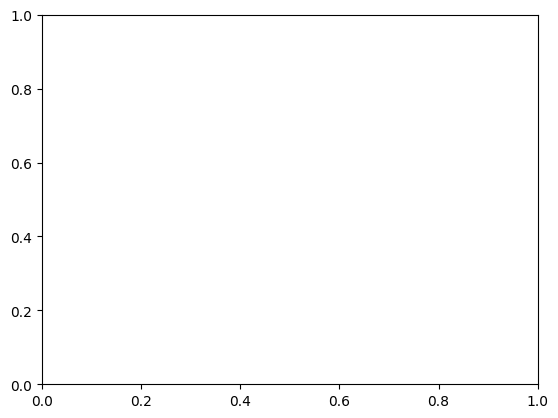

In [115]:
sample = X_test.sample()
print(sample)
prediction = model.predict(sample)
final_result = index_label[np.argmax(prediction[0])]
print(final_result)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(index_label.items,prediction)
plt.show()